# Kyoto Cherry Blossom Prediction

In [39]:
from pathlib import Path 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

In [40]:
temps_path = Path("Data/kyoto_temps.csv")
temps = pd.read_csv(temps_path)
temps['date'] = pd.to_datetime(temps['date'])
temps['year'] = temps['date'].dt.year
temps['month'] = temps['date'].dt.month
temps['season_year'] = temps['year']
temps.loc[temps['month'] >= 10, 'season_year'] += 1
temps['tavg'] = temps['tavg'].fillna((temps['tmin'] + temps['tmax']) / 2)
temps['doy'] = temps['date'].dt.dayofyear
temps = temps[temps['date'] >= temps.dropna(subset=['tavg'])['date'].min()]
temps = temps.reset_index(drop=True)

bloom_path = Path("Data/kyoto.csv")
bloom = pd.read_csv(bloom_path)
bloom = bloom[bloom['year'] > 1945]
bloom['date'] = pd.to_datetime(bloom['bloom_date'])
bloom['doy'] = bloom['date'].dt.dayofyear


## Diagnostics: Chill Day Distribution

Before fitting the model, we will check how many chill days (tavg < 7.2°C) each season actually accumulates.
This determines the valid range for the grid search — there is no point searching thresholds
higher than what most years can actually reach.

count     80.000000
mean      54.725000
std       23.000261
min        0.000000
25%       43.000000
50%       58.500000
75%       69.250000
max      101.000000
Name: chill_days, dtype: float64

Years with fewer than 40 chill days: 17
Years with fewer than 20 chill days: 7


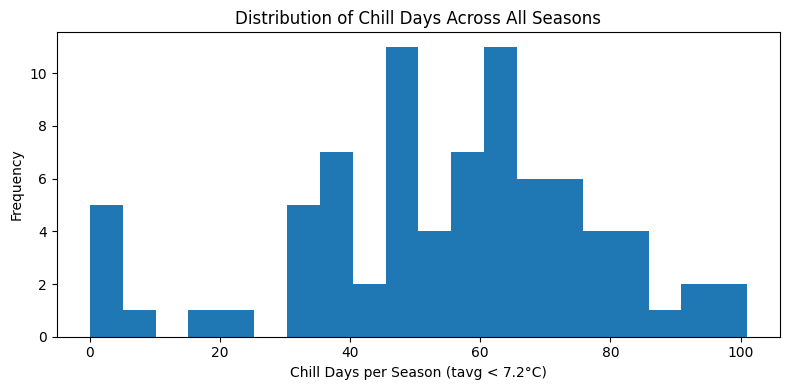

In [41]:
CHILL_BASE = 7.2   # standard chilling hours threshold (°C)
GDD_BASE   = 4.4   # standard GDD base (°C)

chill_counts = []
for y in bloom['year']:
    df_year = temps[temps['season_year'] == y].sort_values('date')
    chill = (df_year['tavg'] < CHILL_BASE).sum()
    chill_counts.append({'year': y, 'chill_days': chill})

chill_df = pd.DataFrame(chill_counts)
print(chill_df['chill_days'].describe())
print(f"\nYears with fewer than 40 chill days: {(chill_df['chill_days'] < 40).sum()}")
print(f"Years with fewer than 20 chill days: {(chill_df['chill_days'] < 20).sum()}")

plt.figure(figsize=(8, 4))
plt.hist(chill_df['chill_days'], bins=20)
plt.xlabel('Chill Days per Season (tavg < 7.2°C)')
plt.ylabel('Frequency')
plt.title('Distribution of Chill Days Across All Seasons')
plt.tight_layout()
plt.show()

## Simulation Function
This function first accumulates chill daily. When the chill threshold is met it starts accumulating heat. Function stops when heat accumulation reaches GDD requirment. The day the function stops is the predicted bloom DOY.

In [43]:
def simulate_bloom_year(temps, bloom_year, chill_threshold, GDD_req,
                        chill_base=7.2, gdd_base=4.4):
    """
    Simulate bloom DOY for a single year.
    1. Accumulate chill days (tavg < chill_base) until threshold met.
    2. Accumulate GDD (max(tavg - gdd_base, 0)) from chill release date.
    3. Return DOY when cumulative GDD >= GDD_req.
    """
    df = temps[temps['season_year'] == bloom_year].copy()
    df = df.sort_values('date')

    chill_cum = 0
    chill_met = False
    chill_date = None

    for _, row in df.iterrows():
        if not chill_met:
            if row['tavg'] < chill_base:
                chill_cum += 1
            if chill_cum >= chill_threshold:
                chill_met = True
                chill_date = row['date']
                break

    if not chill_met:
        return None

    GDD_df = df[df['date'] >= chill_date]
    GDD_cum = 0

    for _, row in GDD_df.iterrows():
        GDD_cum += max(row['tavg'] - gdd_base, 0)
        if GDD_cum >= GDD_req:
            return row['doy']

    return None

## Estimating GDD Requirment From Historical Bloom Dates

This function finds the chill release date for each historical year, and calculates the total GDD from actual bloom. It averages those GDD values and that average becomes the GDD requirement. 

In [44]:
def estimate_GDD_requirement(temps, bloom_df, chill_threshold,
                              chill_base=7.2, gdd_base=4.4):
    """
    For each historical year, we find the chill release date then sum GDD
    up to the actual bloom date. Return the mean GDD across all years
    where the chill threshold was met.
    """
    GDD_values = []

    for year in bloom_df['year']:
        df = temps[temps['season_year'] == year].copy()
        df = df.sort_values('date')
        bloom_doy = bloom_df.loc[bloom_df['year'] == year, 'bloom_doy'].values[0]

        chill_cum = 0
        chill_met = False
        GDD_cum = 0

        for _, row in df.iterrows():
            if not chill_met:
                if row['tavg'] < chill_base:
                    chill_cum += 1
                if chill_cum >= chill_threshold:
                    chill_met = True
            else:
                if row['doy'] <= bloom_doy:
                    GDD_cum += max(0, row['tavg'] - gdd_base)
                else:
                    break

        if chill_met:
            GDD_values.append(GDD_cum)

    if len(GDD_values) == 0:
        return None

    return np.mean(GDD_values)

## Threshold Model Evaluation

In [45]:
def evaluate_threshold(temps, bloom_df, chill_threshold, min_predictions=10):
    GDD_req = estimate_GDD_requirement(temps, bloom_df, chill_threshold)

    if GDD_req is None:
        return None, None, None

    predictions = []
    actuals = []

    for year in bloom_df['year']:
        pred = simulate_bloom_year(temps, year, chill_threshold, GDD_req)

        if pred is not None:
            predictions.append(pred)
            actuals.append(
                bloom_df.loc[bloom_df['year'] == year, 'bloom_doy'].values[0]
            )

    if len(predictions) < min_predictions:
        return None, None, None

    mae = mean_absolute_error(actuals, predictions)
    r2  = r2_score(actuals, predictions)

    return mae, r2, GDD_req

## Grid Search for Optimal Chill Threshold
Estimating chill threshold using GDD multiplier gird. Without grid search, the GDD requirment would just be the mean heat accumulation, which makes the GDD requirment fixed. 

In [46]:
# Set range from diagnostic: adjust if your distribution looks different
chill_min = max(5,  int(chill_df['chill_days'].quantile(0.10)))
chill_max =        int(chill_df['chill_days'].quantile(0.90))
print(f"Grid search range: {chill_min} – {chill_max} chill days")

results = []

for t in range(chill_min, chill_max + 1):
    mae, r2, GDD_req = evaluate_threshold(temps, bloom, t)

    if mae is None:
        continue

    results.append((t, mae, r2, GDD_req))

results_df = pd.DataFrame(
    results,
    columns=['chill_threshold', 'mae', 'r2', 'GDD_requirement']
)

best_row = results_df.loc[results_df['mae'].idxmin()]
print("\nBest result:")
print(best_row)

print(f"\nYears with predictions at best threshold: ", end="")
best_threshold = int(best_row['chill_threshold'])
best_GDD       = best_row['GDD_requirement']
n_preds = sum(
    simulate_bloom_year(temps, y, best_threshold, best_GDD) is not None
    for y in bloom['year']
)
print(f"{n_preds} / {len(bloom)}")

Grid search range: 31 – 81 chill days

Best result:
chill_threshold     52.000000
mae                  2.934783
r2                   0.046905
GDD_requirement    203.580556
Name: 21, dtype: float64

Years with predictions at best threshold: 46 / 80


Interesting result here, the MAE for Kyoto is lower than what we got for DC: 3.02, but has a sigificantly lower $R^2$ compared to DC: 0.62. This means the model is getting predictions close to the actual but can only explain about 8% of the variation in bloom dates. 

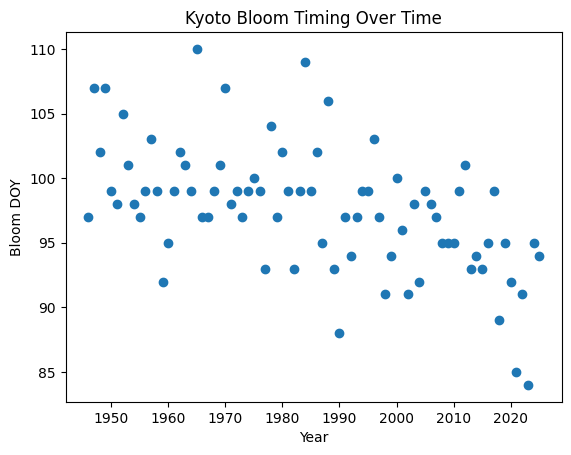

In [47]:
plt.scatter(bloom["year"], bloom["bloom_doy"])
plt.xlabel("Year")
plt.ylabel("Bloom DOY")
plt.title("Kyoto Bloom Timing Over Time")
plt.show()

No discernible trend, and lots of scatter in Kyoto bloom timing over time. This means no model will have an easy time explaining the variance in bloom dates as it naturally varies quite a lot. 

## Optimized Model

In [48]:
predictions = []
actuals     = []
pred_years  = []

for year in bloom['year']:
    pred = simulate_bloom_year(temps, year, best_threshold, best_GDD)

    if pred is not None:
        predictions.append(pred)
        actuals.append(bloom.loc[bloom['year'] == year, 'bloom_doy'].values[0])
        pred_years.append(year)

print("Final MAE:", mean_absolute_error(actuals, predictions))
print("Final R²: ", r2_score(actuals, predictions))

Final MAE: 2.9347826086956523
Final R²:  0.04690541585557728


Best model by far, predictions are about ±1.75 days on average.  

### Optimization Plot

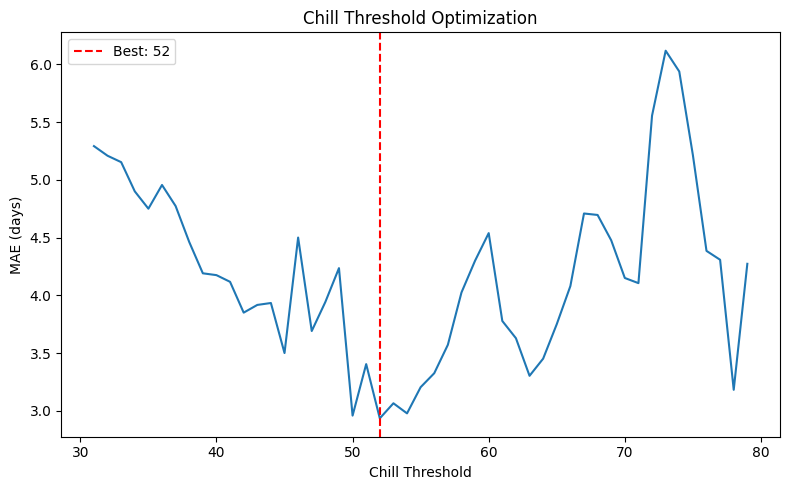

In [53]:
plt.figure(figsize=(8, 5))
plt.plot(results_df['chill_threshold'], results_df['mae'])
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best: {best_threshold}')
plt.xlabel('Chill Threshold')
plt.ylabel('MAE (days)')
plt.title('Chill Threshold Optimization')
plt.legend()
plt.tight_layout()
plt.show()

Linear trend showing confidence in the effect of chilling threshold values on predictions. 

### Rolling Origin Cross-Validation
A time-series cross-validation technique where the model trains on a sequential window of time, tested on the subsequent period, and the window rolls to include new intervals for subsequent iterations. Bloon timing is time-depeendent and climate trend, more so than ever, matter. This mimics what real forecasting has shown, while preventing overfitting and accidental leakage.

In [10]:
# cv_results = []

# years = sorted(bloom["year"].unique())

# for t in range(40, 120):
#     errors = []

#     for i in range(10, len(years)):
#         train_years = years[:i]
#         test_year = years[i]
#         gdd_list = []

#         for y in train_years:
#             actual_doy = bloom.loc[bloom["year"] == y, "doy"].values[0]
#             df_year = temps[temps["season_year"] == y].sort_values("date")
#             chill, gdd = 0, 0

#             for _, row in df_year.iterrows():
#                 if chill < t:
#                     if row["tavg"] < 7.2 and (row["month"] >= 10 or row["month"] <= 2):
#                         chill += 1
#                 else:
#                     if row["doy"] <= actual_doy:
#                         gdd += max(0, row["tavg"] - 4.4)
#                     else:
#                         break

#             gdd_list.append(gdd)

#         if len(gdd_list) == 0:
#             continue

#         GDD_req_train = np.mean(gdd_list)
#         pred = simulate_bloom_year(temps, test_year, t, GDD_req_train)

#         if pred is not None:
#             actual = bloom.loc[bloom["year"] == test_year, "doy"].values[0]
#             errors.append(pred - actual)

#     if len(errors) == 0:
#         continue

#     errors = np.array(errors)
#     cv_results.append((t, np.mean(np.abs(errors)), np.mean(errors)))

# cv_results_df = pd.DataFrame(cv_results, columns=["chill_threshold", "cv_mae", "cv_bias"])
# best_row = cv_results_df.loc[cv_results_df["cv_mae"].idxmin()]

# print(f"  Best Chill Threshold:  {int(best_row['chill_threshold'])} days")
# print(f"  Cross-Validated MAE:   {best_row['cv_mae']:.2f} days")
# print(f"  Mean Bias:             {best_row['cv_bias']:.2f} days")


### GDD Requriement using All Historical Years

In [50]:
best_GDD_full = estimate_GDD_requirement(temps, bloom, best_threshold)
print("Final GDD Requirement:", best_GDD_full)
print("Should match best_row GDD_requirement:", best_row['GDD_requirement'])

Final GDD Requirement: 203.58055555555552
Should match best_row GDD_requirement: 203.58055555555552


## Diagnostics

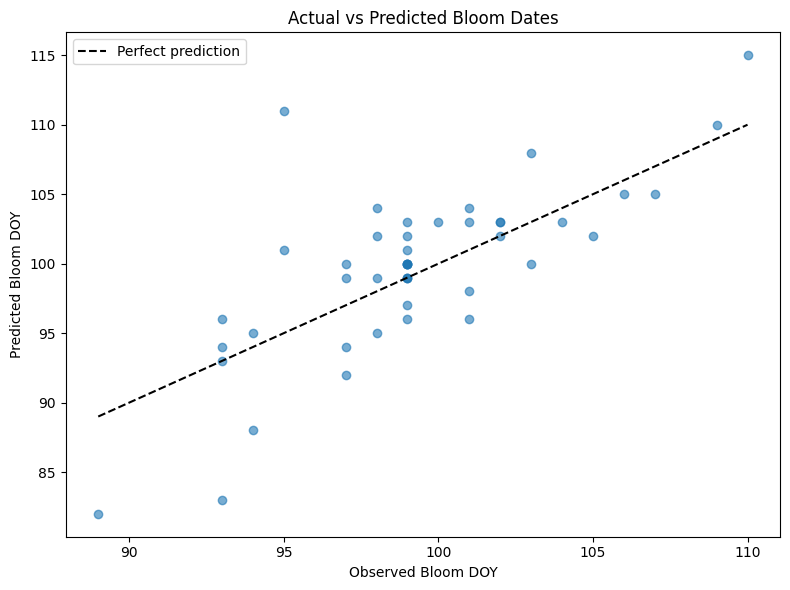

In [54]:
plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, alpha=0.6)
plt.plot(
    [min(actuals), max(actuals)],
    [min(actuals), max(actuals)],
    'k--', label='Perfect prediction'
)
plt.xlabel('Observed Bloom DOY')
plt.ylabel('Predicted Bloom DOY')
plt.title('Actual vs Predicted Bloom Dates')
plt.legend()
plt.tight_layout()
plt.show()

### Residuals vs Year

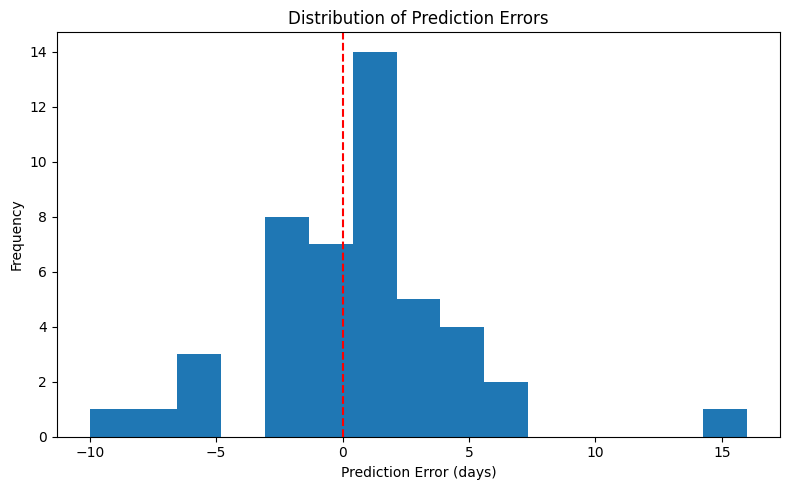

Mean bias: 0.46 days
Std dev:   4.08 days


In [55]:
residuals = np.array(predictions) - np.array(actuals)
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=15)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Prediction Error (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.tight_layout()
plt.show()

print(f"Mean bias: {residuals.mean():.2f} days")
print(f"Std dev:   {residuals.std():.2f} days")

### Residuals Over Time

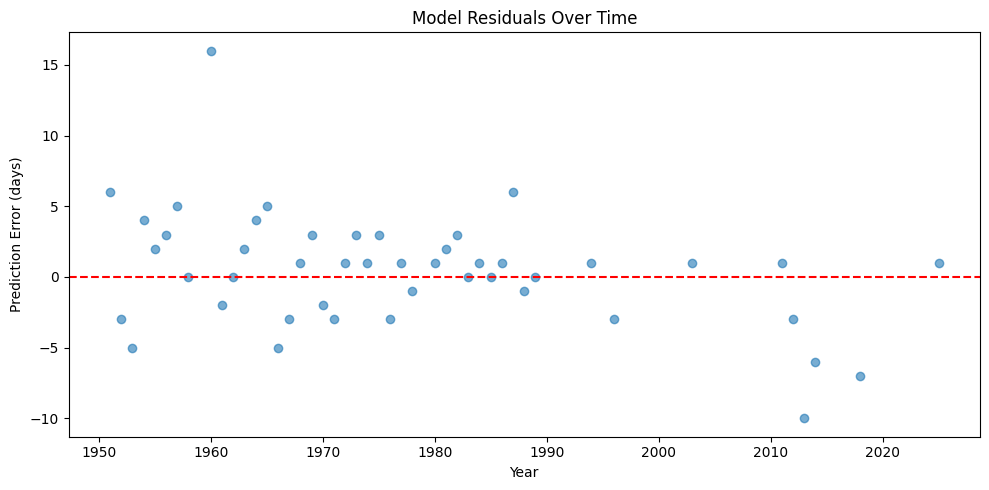

In [56]:
plt.figure(figsize=(10, 5))
plt.scatter(pred_years, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Prediction Error (days)')
plt.title('Model Residuals Over Time')
plt.tight_layout()
plt.show()

### Stability Plot 

In [15]:
# abs_errors = np.abs(residuals)

# plt.figure(figsize=(10, 5))
# plt.plot(bloom["year"], abs_errors)

# plt.xlabel("Year")
# plt.ylabel("Absolute Error (Days)")
# plt.title("Absolute Prediction Error Over Time")

# plt.tight_layout()
# plt.show()

## 2026 Predictions

In [67]:
temps_2026_path = Path('Data/forecast_2026_kyoto.csv')
temps_2026 = pd.read_csv(temps_2026_path)
temps_2026['date']        = pd.to_datetime(temps_2026['date'])
temps_2026['year']        = temps_2026['date'].dt.year
temps_2026['month']       = temps_2026['date'].dt.month
temps_2026['doy']         = temps_2026['date'].dt.dayofyear
temps_2026['tavg']        = temps_2026['tavg'].fillna(
    (temps_2026['tmin'] + temps_2026['tmax']) / 2
)
temps_2026['season_year'] = np.where(
    temps_2026['month'] >= 10,
    temps_2026['year'] + 1,
    temps_2026['year']
)

# Prepend Oct–Dec 2025 from historical data
oct_dec_2025    = temps[temps['season_year'] == 2026].copy()
temps_2026_full = pd.concat([oct_dec_2025, temps_2026], ignore_index=True)
temps_2026_full = temps_2026_full.drop_duplicates(subset=['date']).sort_values('date')

prediction_2026 = simulate_bloom_year(
    temps_2026_full, 2026, best_threshold, best_GDD_full
)

if prediction_2026 is not None:
    pred_date = pd.Timestamp('2026-01-01') + pd.Timedelta(days=prediction_2026 - 1)
    print(f"Kyoto 2026 Predicted Bloom: DOY {prediction_2026} ({pred_date.strftime('%B %d, %Y')})")
else:
    df = temps_2026_full[temps_2026_full['season_year'] == 2026].sort_values('date')
    chill = (df['tavg'] < CHILL_BASE).sum()
    print(f"Chill days accumulated: {chill} (threshold: {best_threshold})")

Chill days accumulated: 46 (threshold: 52)


In [32]:
temps_2026_path = Path("Data/forecast_2026_kyoto.csv")
temps_2026 = pd.read_csv(temps_2026_path)
temps_2026['date'] = pd.to_datetime(temps_2026['date'])
temps_2026['year'] = temps_2026['date'].dt.year
temps_2026['month'] = temps_2026['date'].dt.month
temps_2026['doy'] = temps_2026['date'].dt.dayofyear
temps_2026['tavg'] = temps_2026['tavg'].fillna((temps_2026['tmin'] + temps_2026['tmax']) / 2)
temps_2026['season_year'] = np.where(
    temps_2026['month'] >= 10,
    temps_2026['year'] + 1,
    temps_2026['year']
)

oct_dec_2025 = temps[temps["season_year"] == 2026].copy()
temps_2026_full = pd.concat([oct_dec_2025, temps_2026], ignore_index=True)
temps_2026_full = temps_2026_full.drop_duplicates(subset=["date"]).sort_values("date")


In [68]:
best_threshold = int(best_row["chill_threshold"])
best_GDD_full = best_row["GDD_requirement"]

prediction_2026 = simulate_bloom_year(
    temps_2026_full,
    2026,
    41,
    best_GDD_full
)

print("Kyoto 2026 Predicted Peak Bloom Date: ", prediction_2026)

Kyoto 2026 Predicted Peak Bloom Date:  92
